In [1]:
import os
import sys

import mlflow
import torch
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
FIGURE_DIR = os.getcwd()
MIL_DIR = os.path.dirname(FIGURE_DIR)
NB_DIR = os.path.dirname(MIL_DIR)
ROOT_DIR = os.path.dirname(NB_DIR)
EXP_DIR = os.path.join(ROOT_DIR, "experiments")
sys.path.append(ROOT_DIR)
from mlflow_settings import TRACKING_URI
from utils.serialization_ops import load_pickle
from experiments.MIL.exps.run_train_baseline import select_sample_dataset
from core.datasets import ExSCNVDataset
from core.data_model import PatientDataSet
from core.evaluation import MILModelEvaluator
from core.metric import Metric

mlflow.set_tracking_uri(TRACKING_URI)
from setting import PARENT_RUN_ID

Figure 2-A

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


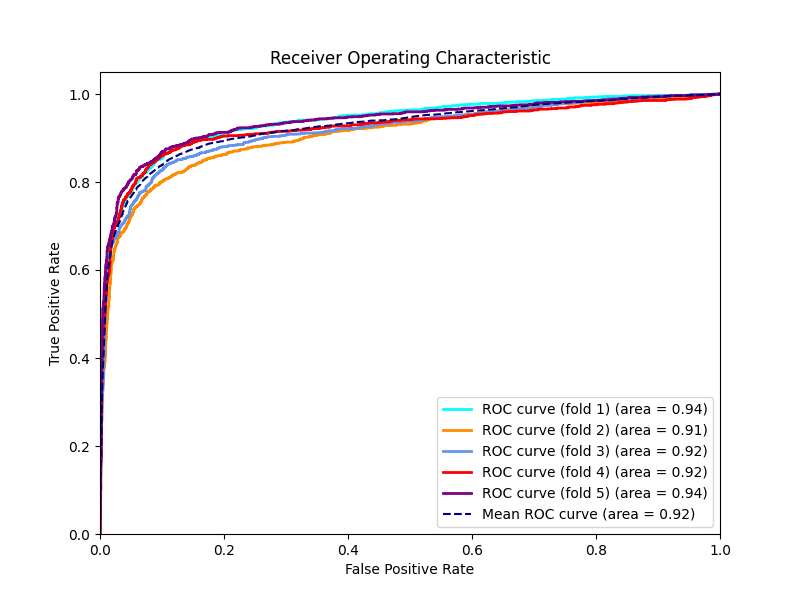

In [2]:
from PIL import Image
auroc = mlflow.artifacts.download_artifacts(f"mlflow-artifacts:/6/{PARENT_RUN_ID}/artifacts/cv_auroc.png")

Image.open(auroc)

Figure 2-B

In [3]:
# Color change
import seaborn as sns
sns.set_context('paper')
sns.set_color_codes('pastel')

In [4]:
from utils.serialization_ops import load_pickle
fold_result = mlflow.artifacts.download_artifacts(f"mlflow-artifacts:/6/{PARENT_RUN_ID}/artifacts/fold_result.pickle")
result = load_pickle(fold_result)

In [5]:
import numpy as np
from core.metric import topk_recall
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

n_fold = 5
performance = np.ones((5, len(ks)))

for k_idx, k in enumerate(ks):
    for fold_idx, (instance_y_trues_at_fold, instance_y_probs_at_fold) in enumerate(zip(result["fold_instance_y_trues"], result["fold_instance_y_probs"])):
        hits = list()
        for instance_y_true, instance_y_probs in zip(instance_y_trues_at_fold, instance_y_probs_at_fold):
            if instance_y_true.sum() == 0:
                continue

            hit = topk_recall(instance_y_probs, instance_y_true, k=k)
            hits.append(hit)

        performance[fold_idx, k_idx] = sum(hits) / len(hits)

print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performance.std(axis=0) * 100)

------------------------------AVG------------------------------
[73.94720688 88.26273788 93.14917127 95.7888275  96.82013505 98.20748926
 98.61264579 98.75997545 99.42295887]
------------------------------SD------------------------------
[2.86478412 1.61410224 0.83954922 0.36750472 0.26729946 0.45177089
 0.45376841 0.49476837 0.38747044]


<Axes: >

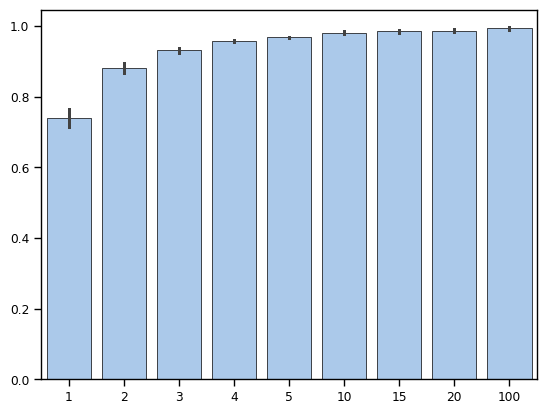

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
df.to_csv("snv_cnv_topk.csv", index=True)
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)

Figure 2-C

In [7]:
from setting import DATASET_PATH
dataset = load_pickle(DATASET_PATH)
with open(os.path.join(EXP_DIR, "external_test_snv_sample_ids.txt")) as fh:
    external_snv_sample_ids = [line.strip() for line in fh.readlines()]
with open(os.path.join(EXP_DIR, "external_test_cnv_sample_ids.txt")) as fh:
    external_cnv_sample_ids = [line.strip() for line in fh.readlines()]

ext_snv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_snv_sample_ids, dataset
)
ext_cnv_patient_dataset, train_val_test_dataset = select_sample_dataset(
    external_cnv_sample_ids, train_val_test_dataset
)

------------------------------AVG------------------------------
[72.26758722 82.82842384 88.14310916 91.42017692 94.98432602 97.49216301
 98.40125392 98.40125392 99.09090909]
------------------------------SD------------------------------
[6.38615939 7.78266265 6.23675244 3.7724377  5.06732806 3.55215435
 1.98855819 1.98855819 1.81818182]


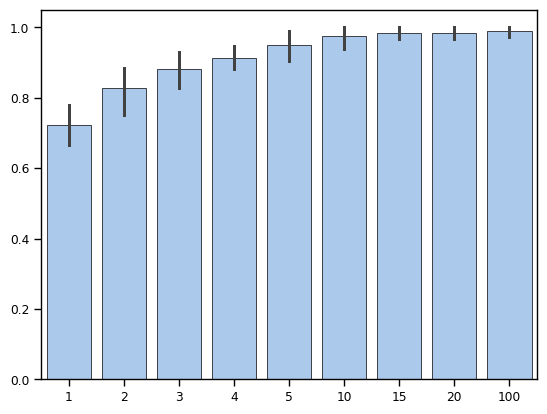

In [8]:
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
n_fold = 5
performance = np.ones((5, len(ks)))

RANDOM_STATE = 20230524

stratified_kfold = StratifiedKFold(5, random_state=RANDOM_STATE, shuffle=True)
stratified_kflod_iter = stratified_kfold.split(
    train_val_test_dataset, train_val_test_dataset.bag_labels
)
for fold, (train_val_indices, test_indice) in enumerate(stratified_kflod_iter, start=0):
    train_indices, val_indices = train_test_split(
        np.arange(len(train_val_indices)),
        test_size=0.11,
        random_state=RANDOM_STATE,
        stratify=train_val_test_dataset.bag_labels[train_val_indices],
    )

    test_dataset = dataset[test_indice]
    instance_y_trues_at_fold, instance_y_probs_at_fold = result["fold_instance_y_trues"][fold], result["fold_instance_y_probs"][fold]
    for k_idx, k in enumerate(ks):
        hits = list()
        for instance_y_true, instance_y_probs, patient_data in zip(instance_y_trues_at_fold, instance_y_probs_at_fold, test_dataset):
            if instance_y_true.sum() == 0:
                continue

            if not patient_data.cnv_data.causal_variant:
                continue

            if patient_data.snv_data.causal_variant != [("-", "-")]:
                continue

            hit = topk_recall(instance_y_probs, instance_y_true, k=k)
            hits.append(hit)

        performance[fold, k_idx] = sum(hits) / len(hits)

df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
df.to_csv("cnv_topk.csv", index=True)
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)


print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performance.std(axis=0) * 100)